In [1]:
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential
import matplotlib.pyplot as plt
import seaborn as sns

#for RBN
from keras.layers import Layer, Flatten, Dense
from keras import backend as K
from sklearn.metrics import classification_report


from sklearn.model_selection import StratifiedKFold
from keras import regularizers
from tensorflow.keras.utils import to_categorical


In [2]:
#fixed random seed for reproducibility 
np.random.seed(0)

In [3]:

# load dataset (input variables = X, output variables = Y)
df = pd.read_csv("TrainingData.csv")

#count the number of occurances for each osID
OsID_counts = df['OsID'].value_counts()

#filter for osIDs that have 10 or more occurances
OsID_counts_filtered = OsID_counts[OsID_counts >= 10]

#assign a label for each osID 
OsID_labels = {}
class_no = 1
for osID in OsID_counts_filtered.index:
    OsID_labels[osID] = class_no
    class_no +=1

#filter the dataset with osID that contain 10 or more occurances
dataGene = df[df['OsID'].isin(OsID_counts_filtered.index)]

dataGene = dataGene.drop(['Class', 'Trait'],axis=1)

# Add a new column 'class' to the filtered dataset
dataGene['class'] = dataGene['OsID'].map(OsID_labels)

#print("Summary of dataGene:\n",dataGene.describe())


In [4]:
X = dataGene.drop(['class','OsID'], axis=1) # exclude class & OsID column
Y = dataGene['class']

#input feature names in order of descending importance scores in RF feature selection method
feature_names = ['Root10DaysSeedling', 'Leaf45DaysOldPlant', 'Shoot10DaysSeedling', 'Shoot35DaysSeedling', 'Root35DaysSeedling', 
                 'Leaf21DaysSeedling', 'Root14DaysSeedling', 'Shoot3DaysSeedling', 'Root24DaysSeedling', 'Root52DaysSeedling', 
                 'Root17DaysSeedling', 'Root21DaysSeedling', 'Shoot14DaysSeedling', 'Shoot21DaysSeedling', 'Shoot17DaysSeedling',
                  'ET', 'PCC', 'log_2FoldChange', 'PPI', 'CoExpression' ]

X_fs = X.reindex(columns=feature_names)

print("Shape of X:\n",X_fs.shape)
print("Shape of Y:\n",Y.shape)

# Statistical summary of the variables
#print("Summary of X:\n",X_fs.describe())
#print("Summary of Y:\n",Y.describe())

# Check for class imbalance
print(df.groupby(Y).size())

# change both input and target variables datatype to ndarray
X_fs = X_fs.values # 2-D array

# select target variable 

Y = Y.values #1-D array
Y = Y.reshape(-1, 1)

Shape of X:
 (41110, 20)
Shape of Y:
 (41110,)
class
1.0      1800
2.0      1296
3.0      1260
4.0      1218
5.0      1026
6.0      1008
7.0       930
8.0       912
9.0       880
10.0      798
11.0      792
12.0      759
13.0      729
14.0      720
15.0      702
16.0      693
17.0      672
18.0      640
19.0      625
20.0      570
21.0      546
22.0      506
23.0      483
24.0      448
25.0      432
26.0      384
27.0      360
28.0      360
29.0      320
30.0      312
         ... 
344.0      12
345.0      12
346.0      12
347.0      12
348.0      12
349.0      12
350.0      12
351.0      12
352.0      12
353.0      12
354.0      12
355.0      12
356.0      11
357.0      11
358.0      11
359.0      11
360.0      11
361.0      11
362.0      10
363.0      10
364.0      10
365.0      10
366.0      10
367.0      10
368.0      10
369.0      10
370.0      10
371.0      10
372.0      10
373.0      10
Length: 373, dtype: int64


C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Class=0, n=1800 (4.378%)
Class=1, n=1296 (3.153%)
Class=2, n=1260 (3.065%)
Class=3, n=1218 (2.963%)
Class=4, n=1026 (2.496%)
Class=5, n=1008 (2.452%)
Class=6, n=930 (2.262%)
Class=7, n=912 (2.218%)
Class=8, n=880 (2.141%)
Class=9, n=798 (1.941%)
Class=10, n=792 (1.927%)
Class=11, n=759 (1.846%)
Class=12, n=729 (1.773%)
Class=13, n=720 (1.751%)
Class=14, n=702 (1.708%)
Class=15, n=693 (1.686%)
Class=16, n=672 (1.635%)
Class=17, n=640 (1.557%)
Class=18, n=625 (1.520%)
Class=19, n=570 (1.387%)
Class=20, n=546 (1.328%)
Class=21, n=506 (1.231%)
Class=22, n=483 (1.175%)
Class=23, n=448 (1.090%)
Class=24, n=432 (1.051%)
Class=25, n=384 (0.934%)
Class=26, n=360 (0.876%)
Class=27, n=360 (0.876%)
Class=28, n=320 (0.778%)
Class=29, n=312 (0.759%)
Class=30, n=312 (0.759%)
Class=31, n=306 (0.744%)
Class=32, n=304 (0.739%)
Class=33, n=299 (0.727%)
Class=34, n=297 (0.722%)
Class=35, n=296 (0.720%)
Class=36, n=280 (0.681%)
Class=37, n=264 (0.642%)
Class=38, n=260 (0.632%)
Class=39, n=253 (0.615%)
Clas

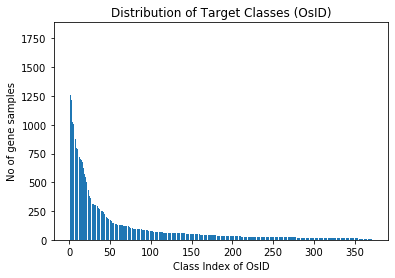

In [5]:
y_labelenc = LabelEncoder().fit_transform(Y)

from collections import Counter
# summarize distribution
counter = Counter(y_labelenc)

# sort counter by keys
counter = dict(sorted(counter.items()))


for k,v in counter.items():
 per = v / len(y_labelenc) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar( counter.keys(), counter.values())

plt.ylabel('No of gene samples')
plt.xlabel('Class Index of OsID')
plt.title('Distribution of Target Classes (OsID)')
plt.show()

In [6]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [7]:
# define the RBFLayer layer as a custom layer
class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff, 2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

In [8]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [9]:
# define baseline model (RBFN)
def RBFN_model(input_dim):

    model = Sequential()
    model.add(Flatten(input_shape=(input_dim,)))
    #add the RBF layer
    model.add(RBFLayer(10, 0.5))
    
    model.add(Dense(60, input_dim=input_dim, activation='relu',bias_initializer='normal',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(373,kernel_initializer='normal',activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [10]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_fs, Y, test_size=0.33, random_state=1)

# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)


C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [11]:
# Define the number of folds for k-fold cross-validation
k = 2

# Define the cross-validation method
cv_method = StratifiedKFold(n_splits=k)

# Initialize the list to store the history, train & validation(accuracy & loss) for each model
models = []
model_history = []
model_accuracy = []
model_train_acc = []
model_train_loss = []
model_val_acc = []
model_val_loss = []


for i in range(1,21):

    models_fold = []
    hist = []
    train_accuracy = []
    train_loss = []
    val_accuracy = []
    val_loss = []
    test_accuracy = []

    print("Number of input features:",i)

    # Select the input features from the input data
    X_train_selected = X_train[:, :i]
    X_test_selected = X_test[:, :i]

    # Loop over the folds
    for fold, (train_index, val_index) in enumerate(cv_method.split(X_train_selected, y_train)):

        print("Fold:", fold+1)

        # Split the data into train and validation sets using the current fold index
        X_train_fold  = X_train_selected[train_index]
        y_train_fold  = y_train[train_index]
        X_val_fold = X_train_selected[val_index]
        y_val_fold = y_train[val_index]

        # Prepare the target data
        y_train_fold_enc, y_val_fold_enc = prepare_targets(y_train_fold, y_val_fold)

        # build the model
        model = RBFN_model(i)

        # Fit the model to the training data for the current fold
        history = model.fit(X_train_fold, to_categorical(y_train_fold_enc, num_classes=373), epochs=100, batch_size=5, verbose=1, validation_split = 0.33)
    
        # Evaluate the model on the validation data for the current fold
        val_scores = model.evaluate(X_val_fold, to_categorical(y_val_fold_enc, num_classes=373), verbose=0)
        val_accuracy.append(val_scores[1])
        val_loss.append(val_scores[0])

        # Evaluate the model on the test data for the current fold
        test_scores = model.evaluate(X_test_selected, to_categorical(y_test_enc, num_classes=373), verbose=0)
        test_accuracy.append(test_scores[1])

        # add the model to the list of models
        models_fold.append(model)
        hist.append(history)

        # store the training accuracy and loss for each fold
        train_accuracy.append(history.history['accuracy'])
        train_loss.append(history.history['loss'])
        
    # Calculate the average test and validation accuracy and loss across all folds
    avg_test_acc = sum(test_accuracy) / len(test_accuracy)
    avg_val_acc = sum(val_accuracy) / len(val_accuracy)
    avg_val_loss = sum(val_loss) / len(val_loss)

    # Print the average validation and test accuracy and loss
    print("Average Validation Accuracy:", avg_val_acc)
    print("Average Validation Loss:",avg_val_loss)
    print("Average Test Accuracy:", avg_test_acc)

    best_fold_index = test_accuracy.index(max(test_accuracy))
    model_accuracy.append(test_accuracy[best_fold_index])
    models.append(models_fold[best_fold_index])
    model_history.append(hist[best_fold_index])
    model_train_acc.append(train_accuracy[best_fold_index])
    model_train_loss.append(train_loss[best_fold_index])
    model_val_acc.append(val_accuracy[best_fold_index])
    model_val_loss.append(val_loss[best_fold_index])


    print("Final Test Accuracy for each fold:", test_accuracy[best_fold_index])

Number of input features: 1
Fold: 1


C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 14s 5ms/step - loss: 5.0109 - accuracy: 0.0402 - val_loss: 4.9343 - val_accuracy: 0.0315
Epoch 2/100
1846/1846 [==============================] - 8s 4ms/step - loss: 4.6282 - accuracy: 0.0797 - val_loss: 4.3609 - val_accuracy: 0.1210
Epoch 3/100
1846/1846 [==============================] - 8s 4ms/step - loss: 4.0089 - accuracy: 0.1331 - val_loss: 3.9603 - val_accuracy: 0.1595
Epoch 4/100
1846/1846 [==============================] - 8s 4ms/step - loss: 3.6984 - accuracy: 0.1730 - val_loss: 3.7722 - val_accuracy: 0.1800
Epoch 5/100
1846/1846 [==============================] - 7s 4ms/step - loss: 3.4885 - accuracy: 0.2131 - val_loss: 3.5669 - val_accuracy: 0.2128
Epoch 6/100
1846/1846 [==============================] - 8s 4ms/step - loss: 3.3097 - accuracy: 0.2364 - val_loss: 3.4483 - val_accuracy: 0.2524
Epoch 7/100
1846/1846 [==============================] - 8s 4ms/step - loss: 3.1507 - accuracy: 0.2605 - val_loss: 3.3135 - val_a

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 15s 5ms/step - loss: 5.0073 - accuracy: 0.0414 - val_loss: 4.8318 - val_accuracy: 0.0750
Epoch 2/100
1846/1846 [==============================] - 9s 5ms/step - loss: 4.3071 - accuracy: 0.1200 - val_loss: 4.1388 - val_accuracy: 0.1681
Epoch 3/100
1846/1846 [==============================] - 8s 4ms/step - loss: 3.8138 - accuracy: 0.1783 - val_loss: 3.7733 - val_accuracy: 0.2352
Epoch 4/100
1846/1846 [==============================] - 9s 5ms/step - loss: 3.4711 - accuracy: 0.2210 - val_loss: 3.4796 - val_accuracy: 0.2867
Epoch 5/100
1846/1846 [==============================] - 8s 4ms/step - loss: 3.1075 - accuracy: 0.2856 - val_loss: 3.0669 - val_accuracy: 0.3545
Epoch 6/100
1846/1846 [==============================] - 8s 4ms/step - loss: 2.6158 - accuracy: 0.4041 - val_loss: 2.5322 - val_accuracy: 0.4345
Epoch 7/100
1846/1846 [==============================] - 8s 4ms/step - loss: 2.1760 - accuracy: 0.4794 - val_loss: 2.2108 - val_a

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 14s 5ms/step - loss: 4.9539 - accuracy: 0.0520 - val_loss: 4.5450 - val_accuracy: 0.0964
Epoch 2/100
1846/1846 [==============================] - 8s 4ms/step - loss: 3.9506 - accuracy: 0.2211 - val_loss: 3.5517 - val_accuracy: 0.3096
Epoch 3/100
1846/1846 [==============================] - 8s 4ms/step - loss: 3.0202 - accuracy: 0.3622 - val_loss: 2.9339 - val_accuracy: 0.3773
Epoch 4/100
1846/1846 [==============================] - 8s 4ms/step - loss: 2.4516 - accuracy: 0.4439 - val_loss: 2.4698 - val_accuracy: 0.4801
Epoch 5/100
1846/1846 [==============================] - 8s 4ms/step - loss: 2.0420 - accuracy: 0.5170 - val_loss: 2.2265 - val_accuracy: 0.5584
Epoch 6/100
1846/1846 [==============================] - 6s 3ms/step - loss: 1.7631 - accuracy: 0.5622 - val_loss: 2.0211 - val_accuracy: 0.5439
Epoch 7/100
1846/1846 [==============================] - 6s 3ms/step - loss: 1.5637 - accuracy: 0.5953 - val_loss: 1.8741 - val_a

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 15s 5ms/step - loss: 4.7696 - accuracy: 0.0920 - val_loss: 4.0978 - val_accuracy: 0.2088
Epoch 2/100
1846/1846 [==============================] - 9s 5ms/step - loss: 3.5392 - accuracy: 0.3061 - val_loss: 3.3519 - val_accuracy: 0.3487
Epoch 3/100
1846/1846 [==============================] - 9s 5ms/step - loss: 2.8509 - accuracy: 0.4162 - val_loss: 2.8297 - val_accuracy: 0.4180
Epoch 4/100
1846/1846 [==============================] - 8s 4ms/step - loss: 2.3630 - accuracy: 0.4993 - val_loss: 2.4525 - val_accuracy: 0.5457
Epoch 5/100
1846/1846 [==============================] - 9s 5ms/step - loss: 1.9782 - accuracy: 0.5804 - val_loss: 2.1896 - val_accuracy: 0.6046
Epoch 6/100
1846/1846 [==============================] - 9s 5ms/step - loss: 1.6997 - accuracy: 0.6237 - val_loss: 1.9983 - val_accuracy: 0.6266
Epoch 7/100
1846/1846 [==============================] - 8s 4ms/step - loss: 1.4915 - accuracy: 0.6618 - val_loss: 1.8502 - val_a

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 16s 5ms/step - loss: 4.7190 - accuracy: 0.0689 - val_loss: 4.1581 - val_accuracy: 0.0964
Epoch 2/100
1846/1846 [==============================] - 9s 5ms/step - loss: 3.6838 - accuracy: 0.2256 - val_loss: 3.4798 - val_accuracy: 0.3342
Epoch 3/100
1846/1846 [==============================] - 9s 5ms/step - loss: 2.9337 - accuracy: 0.4112 - val_loss: 2.8143 - val_accuracy: 0.4482
Epoch 4/100
1846/1846 [==============================] - 8s 4ms/step - loss: 2.2326 - accuracy: 0.5074 - val_loss: 2.2809 - val_accuracy: 0.5406
Epoch 5/100
1846/1846 [==============================] - 9s 5ms/step - loss: 1.7225 - accuracy: 0.5902 - val_loss: 1.9309 - val_accuracy: 0.6521
Epoch 6/100
1846/1846 [==============================] - 8s 4ms/step - loss: 1.4314 - accuracy: 0.6403 - val_loss: 1.7605 - val_accuracy: 0.6251
Epoch 7/100
1846/1846 [==============================] - 9s 5ms/step - loss: 1.2622 - accuracy: 0.6696 - val_loss: 1.6310 - val_a

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 15s 5ms/step - loss: 4.7702 - accuracy: 0.0715 - val_loss: 4.1994 - val_accuracy: 0.1193
Epoch 2/100
1846/1846 [==============================] - 8s 4ms/step - loss: 3.7138 - accuracy: 0.2145 - val_loss: 3.5403 - val_accuracy: 0.3197
Epoch 3/100
1846/1846 [==============================] - 8s 4ms/step - loss: 3.0032 - accuracy: 0.3937 - val_loss: 2.9388 - val_accuracy: 0.4244
Epoch 4/100
1846/1846 [==============================] - 9s 5ms/step - loss: 2.4017 - accuracy: 0.4713 - val_loss: 2.4924 - val_accuracy: 0.5116
Epoch 5/100
1846/1846 [==============================] - 8s 4ms/step - loss: 1.9729 - accuracy: 0.5496 - val_loss: 2.1892 - val_accuracy: 0.5452
Epoch 6/100
1846/1846 [==============================] - 8s 4ms/step - loss: 1.6571 - accuracy: 0.6299 - val_loss: 2.0119 - val_accuracy: 0.5846
Epoch 7/100
1846/1846 [==============================] - 8s 4ms/step - loss: 1.4087 - accuracy: 0.6787 - val_loss: 1.7814 - val_a

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 15s 5ms/step - loss: 4.6107 - accuracy: 0.0599 - val_loss: 4.1117 - val_accuracy: 0.0955
Epoch 2/100
1846/1846 [==============================] - 8s 4ms/step - loss: 3.5518 - accuracy: 0.2452 - val_loss: 3.2737 - val_accuracy: 0.3679
Epoch 3/100
1846/1846 [==============================] - 8s 4ms/step - loss: 2.7368 - accuracy: 0.4479 - val_loss: 2.6940 - val_accuracy: 0.4928
Epoch 4/100
1846/1846 [==============================] - 9s 5ms/step - loss: 2.1868 - accuracy: 0.5389 - val_loss: 2.3253 - val_accuracy: 0.5762
Epoch 5/100
1846/1846 [==============================] - 8s 4ms/step - loss: 1.8078 - accuracy: 0.6189 - val_loss: 2.0354 - val_accuracy: 0.6422
Epoch 6/100
1846/1846 [==============================] - 8s 4ms/step - loss: 1.5399 - accuracy: 0.6665 - val_loss: 1.8823 - val_accuracy: 0.6735
Epoch 7/100
1846/1846 [==============================] - 8s 4ms/step - loss: 1.3537 - accuracy: 0.6905 - val_loss: 1.7360 - val_a

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 10s 4ms/step - loss: 4.6262 - accuracy: 0.0789 - val_loss: 4.0652 - val_accuracy: 0.1347
Epoch 2/100
1846/1846 [==============================] - 6s 3ms/step - loss: 3.5767 - accuracy: 0.2424 - val_loss: 3.3466 - val_accuracy: 0.3798
Epoch 3/100
1846/1846 [==============================] - 6s 3ms/step - loss: 2.8152 - accuracy: 0.4294 - val_loss: 2.7461 - val_accuracy: 0.4832
Epoch 4/100
1846/1846 [==============================] - 7s 4ms/step - loss: 2.2111 - accuracy: 0.5421 - val_loss: 2.2878 - val_accuracy: 0.5762
Epoch 5/100
1846/1846 [==============================] - 6s 3ms/step - loss: 1.8133 - accuracy: 0.6197 - val_loss: 2.0079 - val_accuracy: 0.6354
Epoch 6/100
1846/1846 [==============================] - 6s 3ms/step - loss: 1.5317 - accuracy: 0.6676 - val_loss: 1.8148 - val_accuracy: 0.6638
Epoch 7/100
1846/1846 [==============================] - 6s 3ms/step - loss: 1.3381 - accuracy: 0.6976 - val_loss: 1.7219 - val_a

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 12s 4ms/step - loss: 4.6260 - accuracy: 0.0811 - val_loss: 4.1068 - val_accuracy: 0.1221
Epoch 2/100
1846/1846 [==============================] - 8s 4ms/step - loss: 3.6276 - accuracy: 0.1954 - val_loss: 3.4177 - val_accuracy: 0.2680
Epoch 3/100
1846/1846 [==============================] - 8s 4ms/step - loss: 2.9453 - accuracy: 0.3625 - val_loss: 2.8254 - val_accuracy: 0.4616
Epoch 4/100
1846/1846 [==============================] - 8s 4ms/step - loss: 2.3736 - accuracy: 0.4878 - val_loss: 2.4098 - val_accuracy: 0.5140
Epoch 5/100
1846/1846 [==============================] - 8s 4ms/step - loss: 1.9662 - accuracy: 0.5494 - val_loss: 2.1260 - val_accuracy: 0.5582
Epoch 6/100
1846/1846 [==============================] - 8s 4ms/step - loss: 1.6608 - accuracy: 0.6133 - val_loss: 1.9301 - val_accuracy: 0.6244
Epoch 7/100
1846/1846 [==============================] - 9s 5ms/step - loss: 1.4292 - accuracy: 0.6671 - val_loss: 1.7363 - val_a

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 9s 3ms/step - loss: 4.5359 - accuracy: 0.0928 - val_loss: 4.1363 - val_accuracy: 0.1309
Epoch 2/100
1846/1846 [==============================] - 6s 3ms/step - loss: 3.6831 - accuracy: 0.1819 - val_loss: 3.5450 - val_accuracy: 0.1905
Epoch 3/100
1846/1846 [==============================] - 6s 3ms/step - loss: 3.1542 - accuracy: 0.2585 - val_loss: 3.0554 - val_accuracy: 0.3457
Epoch 4/100
1846/1846 [==============================] - 6s 3ms/step - loss: 2.5938 - accuracy: 0.4306 - val_loss: 2.4975 - val_accuracy: 0.4964
Epoch 5/100
1846/1846 [==============================] - 6s 3ms/step - loss: 2.0269 - accuracy: 0.5651 - val_loss: 2.0304 - val_accuracy: 0.5795
Epoch 6/100
1846/1846 [==============================] - 6s 3ms/step - loss: 1.5749 - accuracy: 0.6440 - val_loss: 1.6802 - val_accuracy: 0.6711
Epoch 7/100
1846/1846 [==============================] - 7s 4ms/step - loss: 1.2658 - accuracy: 0.7068 - val_loss: 1.4758 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 9s 3ms/step - loss: 4.4940 - accuracy: 0.0844 - val_loss: 4.0142 - val_accuracy: 0.1223
Epoch 2/100
1846/1846 [==============================] - 6s 3ms/step - loss: 3.5132 - accuracy: 0.2025 - val_loss: 3.3120 - val_accuracy: 0.2554
Epoch 3/100
1846/1846 [==============================] - 6s 3ms/step - loss: 2.7454 - accuracy: 0.3664 - val_loss: 2.5356 - val_accuracy: 0.4284
Epoch 4/100
1846/1846 [==============================] - 5s 3ms/step - loss: 2.0615 - accuracy: 0.5386 - val_loss: 2.1302 - val_accuracy: 0.5633
Epoch 5/100
1846/1846 [==============================] - 5s 3ms/step - loss: 1.6268 - accuracy: 0.6288 - val_loss: 1.7595 - val_accuracy: 0.6231
Epoch 6/100
1846/1846 [==============================] - 6s 3ms/step - loss: 1.3389 - accuracy: 0.6851 - val_loss: 1.5563 - val_accuracy: 0.6920
Epoch 7/100
1846/1846 [==============================] - 6s 3ms/step - loss: 1.1455 - accuracy: 0.7208 - val_loss: 1.4041 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 10s 4ms/step - loss: 4.4898 - accuracy: 0.0880 - val_loss: 4.0777 - val_accuracy: 0.1311
Epoch 2/100
1846/1846 [==============================] - 5s 3ms/step - loss: 3.6537 - accuracy: 0.1816 - val_loss: 3.5269 - val_accuracy: 0.1685
Epoch 3/100
1846/1846 [==============================] - 5s 3ms/step - loss: 3.0757 - accuracy: 0.2872 - val_loss: 2.9312 - val_accuracy: 0.3870
Epoch 4/100
1846/1846 [==============================] - 5s 3ms/step - loss: 2.3742 - accuracy: 0.4622 - val_loss: 2.3143 - val_accuracy: 0.4955
Epoch 5/100
1846/1846 [==============================] - 5s 3ms/step - loss: 1.8350 - accuracy: 0.5746 - val_loss: 1.9498 - val_accuracy: 0.6088
Epoch 6/100
1846/1846 [==============================] - 5s 3ms/step - loss: 1.4916 - accuracy: 0.6411 - val_loss: 1.6819 - val_accuracy: 0.6598
Epoch 7/100
1846/1846 [==============================] - 5s 3ms/step - loss: 1.2774 - accuracy: 0.6864 - val_loss: 1.4986 - val_a

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 14s 4ms/step - loss: 4.4845 - accuracy: 0.0930 - val_loss: 3.9591 - val_accuracy: 0.1721
Epoch 2/100
1846/1846 [==============================] - 7s 4ms/step - loss: 3.4319 - accuracy: 0.2678 - val_loss: 3.1698 - val_accuracy: 0.3800
Epoch 3/100
1846/1846 [==============================] - 7s 4ms/step - loss: 2.6288 - accuracy: 0.4618 - val_loss: 2.5671 - val_accuracy: 0.5127
Epoch 4/100
1846/1846 [==============================] - 7s 4ms/step - loss: 2.0519 - accuracy: 0.5668 - val_loss: 2.1154 - val_accuracy: 0.5877
Epoch 5/100
1846/1846 [==============================] - 7s 4ms/step - loss: 1.6608 - accuracy: 0.6301 - val_loss: 1.8298 - val_accuracy: 0.6598
Epoch 6/100
1846/1846 [==============================] - 7s 4ms/step - loss: 1.4065 - accuracy: 0.6703 - val_loss: 1.6361 - val_accuracy: 0.6851
Epoch 7/100
1846/1846 [==============================] - 7s 4ms/step - loss: 1.2275 - accuracy: 0.7083 - val_loss: 1.5109 - val_a

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 15s 5ms/step - loss: 4.7953 - accuracy: 0.0616 - val_loss: 4.2883 - val_accuracy: 0.1129
Epoch 2/100
1846/1846 [==============================] - 8s 4ms/step - loss: 3.8598 - accuracy: 0.1632 - val_loss: 3.6213 - val_accuracy: 0.2482
Epoch 3/100
1846/1846 [==============================] - 7s 4ms/step - loss: 3.0105 - accuracy: 0.3966 - val_loss: 2.7962 - val_accuracy: 0.4691
Epoch 4/100
1846/1846 [==============================] - 7s 4ms/step - loss: 2.2375 - accuracy: 0.5418 - val_loss: 2.2614 - val_accuracy: 0.5710
Epoch 5/100
1846/1846 [==============================] - 6s 3ms/step - loss: 1.7285 - accuracy: 0.6192 - val_loss: 1.9343 - val_accuracy: 0.6051
Epoch 6/100
1846/1846 [==============================] - 7s 4ms/step - loss: 1.4057 - accuracy: 0.6694 - val_loss: 1.6872 - val_accuracy: 0.6684
Epoch 7/100
1846/1846 [==============================] - 7s 4ms/step - loss: 1.1887 - accuracy: 0.7096 - val_loss: 1.5093 - val_a

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 15s 5ms/step - loss: 4.5635 - accuracy: 0.0712 - val_loss: 4.1038 - val_accuracy: 0.0882
Epoch 2/100
1846/1846 [==============================] - 7s 4ms/step - loss: 3.6863 - accuracy: 0.1550 - val_loss: 3.5026 - val_accuracy: 0.2251
Epoch 3/100
1846/1846 [==============================] - 7s 4ms/step - loss: 3.0574 - accuracy: 0.2900 - val_loss: 2.8649 - val_accuracy: 0.4438
Epoch 4/100
1846/1846 [==============================] - 7s 4ms/step - loss: 2.3422 - accuracy: 0.4910 - val_loss: 2.2606 - val_accuracy: 0.5289
Epoch 5/100
1846/1846 [==============================] - 7s 4ms/step - loss: 1.7967 - accuracy: 0.5932 - val_loss: 1.8236 - val_accuracy: 0.6169
Epoch 6/100
1846/1846 [==============================] - 7s 4ms/step - loss: 1.4711 - accuracy: 0.6581 - val_loss: 1.5840 - val_accuracy: 0.6625
Epoch 7/100
1846/1846 [==============================] - 7s 4ms/step - loss: 1.2507 - accuracy: 0.6964 - val_loss: 1.4202 - val_a

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 16s 5ms/step - loss: 4.7512 - accuracy: 0.0597 - val_loss: 4.2238 - val_accuracy: 0.0904
Epoch 2/100
1846/1846 [==============================] - 7s 4ms/step - loss: 3.8293 - accuracy: 0.1608 - val_loss: 3.6154 - val_accuracy: 0.2286
Epoch 3/100
1846/1846 [==============================] - 8s 4ms/step - loss: 3.1566 - accuracy: 0.2907 - val_loss: 2.9057 - val_accuracy: 0.4156
Epoch 4/100
1846/1846 [==============================] - 7s 4ms/step - loss: 2.4419 - accuracy: 0.4756 - val_loss: 2.3520 - val_accuracy: 0.5507
Epoch 5/100
1846/1846 [==============================] - 7s 4ms/step - loss: 1.9613 - accuracy: 0.5828 - val_loss: 2.0113 - val_accuracy: 0.5908
Epoch 6/100
1846/1846 [==============================] - 7s 4ms/step - loss: 1.6520 - accuracy: 0.6471 - val_loss: 1.7707 - val_accuracy: 0.6557
Epoch 7/100
1846/1846 [==============================] - 6s 3ms/step - loss: 1.4422 - accuracy: 0.6825 - val_loss: 1.6183 - val_a

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 9s 3ms/step - loss: 4.8331 - accuracy: 0.0612 - val_loss: 4.4184 - val_accuracy: 0.1030
Epoch 2/100
1846/1846 [==============================] - 5s 3ms/step - loss: 3.9987 - accuracy: 0.1454 - val_loss: 3.8584 - val_accuracy: 0.1501
Epoch 3/100
1846/1846 [==============================] - 5s 3ms/step - loss: 3.5896 - accuracy: 0.1844 - val_loss: 3.5579 - val_accuracy: 0.2176
Epoch 4/100
1846/1846 [==============================] - 5s 3ms/step - loss: 3.3156 - accuracy: 0.2147 - val_loss: 3.3197 - val_accuracy: 0.2405
Epoch 5/100
1846/1846 [==============================] - 5s 3ms/step - loss: 3.0263 - accuracy: 0.2734 - val_loss: 3.0642 - val_accuracy: 0.2882
Epoch 6/100
1846/1846 [==============================] - 5s 3ms/step - loss: 2.7260 - accuracy: 0.3393 - val_loss: 2.8187 - val_accuracy: 0.3318
Epoch 7/100
1846/1846 [==============================] - 5s 3ms/step - loss: 2.4606 - accuracy: 0.3887 - val_loss: 2.5850 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 8s 3ms/step - loss: 4.7757 - accuracy: 0.0680 - val_loss: 4.2717 - val_accuracy: 0.1151
Epoch 2/100
1846/1846 [==============================] - 5s 3ms/step - loss: 3.8982 - accuracy: 0.1550 - val_loss: 3.7569 - val_accuracy: 0.1883
Epoch 3/100
1846/1846 [==============================] - 5s 3ms/step - loss: 3.3694 - accuracy: 0.2477 - val_loss: 3.2609 - val_accuracy: 0.2847
Epoch 4/100
1846/1846 [==============================] - 5s 3ms/step - loss: 2.8329 - accuracy: 0.3682 - val_loss: 2.8253 - val_accuracy: 0.4097
Epoch 5/100
1846/1846 [==============================] - 5s 3ms/step - loss: 2.4431 - accuracy: 0.4397 - val_loss: 2.5006 - val_accuracy: 0.4392
Epoch 6/100
1846/1846 [==============================] - 5s 3ms/step - loss: 2.1882 - accuracy: 0.4773 - val_loss: 2.3117 - val_accuracy: 0.4895
Epoch 7/100
1846/1846 [==============================] - 5s 3ms/step - loss: 1.9954 - accuracy: 0.5194 - val_loss: 2.1619 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 7s 3ms/step - loss: 4.8623 - accuracy: 0.0542 - val_loss: 4.4590 - val_accuracy: 0.0966
Epoch 2/100
1846/1846 [==============================] - 5s 3ms/step - loss: 4.0791 - accuracy: 0.1326 - val_loss: 3.9388 - val_accuracy: 0.1736
Epoch 3/100
1846/1846 [==============================] - 5s 3ms/step - loss: 3.6101 - accuracy: 0.1900 - val_loss: 3.5346 - val_accuracy: 0.2099
Epoch 4/100
1846/1846 [==============================] - 5s 3ms/step - loss: 3.1756 - accuracy: 0.2795 - val_loss: 3.1127 - val_accuracy: 0.3309
Epoch 5/100
1846/1846 [==============================] - 5s 3ms/step - loss: 2.7469 - accuracy: 0.3696 - val_loss: 2.7570 - val_accuracy: 0.4004
Epoch 6/100
1846/1846 [==============================] - 5s 3ms/step - loss: 2.4232 - accuracy: 0.4378 - val_loss: 2.5358 - val_accuracy: 0.4262
Epoch 7/100
1846/1846 [==============================] - 5s 3ms/step - loss: 2.1845 - accuracy: 0.4850 - val_loss: 2.3291 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 8s 3ms/step - loss: 4.8702 - accuracy: 0.0573 - val_loss: 4.5882 - val_accuracy: 0.1083
Epoch 2/100
1846/1846 [==============================] - 5s 3ms/step - loss: 4.1746 - accuracy: 0.1198 - val_loss: 4.0224 - val_accuracy: 0.1336
Epoch 3/100
1846/1846 [==============================] - 5s 3ms/step - loss: 3.6928 - accuracy: 0.1801 - val_loss: 3.6391 - val_accuracy: 0.1826
Epoch 4/100
1846/1846 [==============================] - 5s 3ms/step - loss: 3.3047 - accuracy: 0.2413 - val_loss: 3.2630 - val_accuracy: 0.2737
Epoch 5/100
1846/1846 [==============================] - 5s 3ms/step - loss: 2.9081 - accuracy: 0.3269 - val_loss: 2.8963 - val_accuracy: 0.3679
Epoch 6/100
1846/1846 [==============================] - 5s 3ms/step - loss: 2.5434 - accuracy: 0.4004 - val_loss: 2.5868 - val_accuracy: 0.4229
Epoch 7/100
1846/1846 [==============================] - 5s 3ms/step - loss: 2.2588 - accuracy: 0.4670 - val_loss: 2.3957 - val_ac

In [12]:
#to show the no of input features and its corresponding model accuracy
model_list = []

#Iterate through each model's accuracy 
for i in range (len(model_accuracy)):
    #get the number of input features for the current model
    no_features = i + 1

    #round the model accuries to 3 d.p.
    rounded_model_acc = round(model_accuracy[i], 3)
    
    model_list.append([no_features, rounded_model_acc])

models_df = pd.DataFrame(model_list, columns=["No of input features", "Model accuracy"])

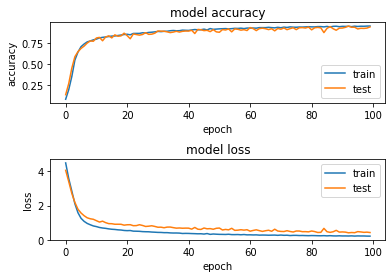

Final Test Accuracy: 0.9580600261688232


In [13]:
# Select the final model based on the max test accuracy across all models

best_model_index = model_accuracy.index(max(model_accuracy))

best_model = models[best_model_index]
best_model_history = model_history[best_model_index]
best_model_train_acc = model_train_acc[best_model_index]
best_model_train_loss = model_train_loss[best_model_index]
best_model_val_acc = model_val_acc[best_model_index]
best_model_val_loss = model_val_loss[best_model_index]

# summarize history for accuracy  
plt.subplot(211)  
plt.plot(best_model_history.history['accuracy'])  
plt.plot(best_model_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='lower right')  

# summarize history for loss
plt.subplot(212)  
plt.plot(best_model_history.history['loss'])  
plt.plot(best_model_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper right')  
plt.subplots_adjust(hspace=0.7)

plt.show() 

print("Final Test Accuracy:", model_accuracy[best_model_index])

In [14]:
#Select only the optimal number of input features for X_test
X_test = X_test[:,:(best_model_index+1)]

# Evaluate the best model on the test data
y_pred = best_model.predict(X_test)

# np.argmax() is used to convert the one-hot encoded predictions and test labels to class labels.
y_pred_label = np.argmax(y_pred, axis = 1)

# Print the classification report
print("Classification report:\n", classification_report(y_test_enc, y_pred_label))

424/424 [==============================] - 1s 2ms/step
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       591
           1       1.00      1.00      1.00       430
           2       1.00      1.00      1.00       419
           3       1.00      1.00      1.00       384
           4       1.00      1.00      1.00       339
           5       1.00      1.00      1.00       342
           6       1.00      1.00      1.00       310
           7       1.00      1.00      1.00       325
           8       0.99      1.00      0.99       294
           9       1.00      1.00      1.00       269
          10       1.00      1.00      1.00       296
          11       1.00      1.00      1.00       258
          12       1.00      1.00      1.00       247
          13       1.00      1.00      1.00       237
          14       1.00      1.00      1.00       239
          15       1.00      1.00      1.00       235
  

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [15]:
# extract class labels from test data
class_test = y_test_enc

# Invert OsID_labels dictionary
inv_OsID_labels = {v: k for k, v in OsID_labels.items()}

# map OsID values to the class labels
OsID_test = [inv_OsID_labels.get(value, 'Unknown') for value in class_test]

# create dataframe with OsID, true class, predicted class, and true/false columns
results = pd.DataFrame({
    'OsID': OsID_test,
    'True Class': y_test_enc,
    'Predicted Class': y_pred_label,
    'True/False': class_test == y_pred_label
})

# display dataframe
print(results.head())

# save results_df to a CSV file
results.to_csv('MLP_gene classification.csv', index=False)

           OsID  True Class  Predicted Class  True/False
0  Os07g0476500         332              302       False
1  Os01g0173100         161              161        True
2  Os01g0686800          17               17        True
3  Os04g0107900          34               34        True
4  Os04g0517100           7                7        True


In [16]:
display(models_df)

,No of input features,Model accuracy
0,1,0.488
1,2,0.840
2,3,0.833
3,4,0.889
4,5,0.949
5,6,0.889
6,7,0.943
7,8,0.944
8,9,0.934
9,10,0.936
